# About

The notebook reveals typical template/workflow for building a plot with matplotlib. A COVID-19 dataset (from  https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset, updated daily) is used to build examples.

# Initialization

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# import constants for the days of the week
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

In [4]:
%matplotlib inline

%config InlineBackend.figure_format = 'png'

# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

The 'matplotlib' library defines different styles, you can select and use whichever you like, check the list of available at https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html. Or you can even define your own style but that requires some learning. Below, the 'seaborn' style is loaded. It provides the same visual appearance as the 'searborn' library.

In [5]:
plt.style.use('seaborn')

Just checking what versions are used.

In [6]:
print(matplotlib.__version__)
print(pd.__version__)
print(sns.__version__)

3.4.1
1.2.4
0.11.1


# Data Load

In [7]:
population = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_936048/API_SP.POP.TOTL_DS2_en_csv_v2_936048.csv', skiprows=4)

In [8]:
population.sample(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
21,"Bahamas, The",BHS,"Population, total",SP.POP.TOTL,109534.0,115121.0,121091.0,127339.0,133709.0,140059.0,...,359577.0,363584.0,367168.0,370633.0,374206.0,377931.0,381761.0,385640.0,NaN,NaN
229,Europe & Central Asia (IDA & IBRD countries),TEC,"Population, total",SP.POP.TOTL,308925209.0,313575168.0,318268089.0,323037300.0,327816760.0,332408546.0,...,443356614.0,445596591.0,448074081.0,450528180.0,453034345.0,455505650.0,457810292.0,459865205.0,NaN,NaN
51,Cyprus,CYP,"Population, total",SP.POP.TOTL,572930.0,576395.0,577691.0,577913.0,578625.0,580966.0,...,1124833.0,1135046.0,1143866.0,1152285.0,1160985.0,1170187.0,1179680.0,1189265.0,NaN,NaN
214,South Sudan,SSD,"Population, total",SP.POP.TOTL,2842724.0,2895605.0,2951043.0,3009062.0,3069739.0,3133150.0,...,9830698.0,10113647.0,10355036.0,10554883.0,10715658.0,10832512.0,10910759.0,10975920.0,NaN,NaN
25,Bermuda,BMU,"Population, total",SP.POP.TOTL,44400.0,45500.0,46600.0,47700.0,48900.0,50100.0,...,64564.0,64798.0,65001.0,65139.0,65239.0,64555.0,63874.0,63973.0,NaN,NaN


In [9]:
df = pd.read_csv('covid_19_data.csv.zip', 
                 index_col='SNo', 
                 dtype={'Country/Region': 'category', 'Confirmed': 'Int64', 'Deaths': 'Int64', 'Recovered': 'Int64'}, 
                 parse_dates=['ObservationDate', 'Last Update'])

Int64 is a new datatype in pandas, it allows having missing (NaN) values without forcibly converting existing values to the 'float' datatype, that is existing values keep the 'int' datatype.

In [10]:
df = df.sort_values(['ObservationDate']).copy()

In [11]:
df.head(5)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1,0,0
23,2020-01-22,Qinghai,Mainland China,2020-01-22 17:00:00,0,0,0
24,2020-01-22,Shaanxi,Mainland China,2020-01-22 17:00:00,0,0,0
25,2020-01-22,Shandong,Mainland China,2020-01-22 17:00:00,2,0,0
26,2020-01-22,Shanghai,Mainland China,2020-01-22 17:00:00,9,0,0


In [12]:
df.tail(5)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
284800,2021-05-02,Casanare,Colombia,2021-05-03 04:20:39,15504,348,14501
284801,2021-05-02,Castilla - La Mancha,Spain,2021-05-03 04:20:39,185354,5851,6392
284802,2021-05-02,Castilla y Leon,Spain,2021-05-03 04:20:39,223100,6754,8716
284793,2021-05-02,Callao,Peru,2021-05-03 04:20:39,91921,3230,0
285307,2021-05-02,Zuid-Holland,Netherlands,2021-05-03 04:20:39,359327,4138,0


In [13]:
df['death_rate'] = (100*df['Deaths']/df['Confirmed']).astype('float').round(1)

# EDA (Somewhat)

Here, we do a bit of EDA just to make familiar with the dataset.

In [14]:
# getting the last day's data for each country/region

df_latest = df.groupby(['ObservationDate', 'Country/Region'])[['Confirmed', 'Deaths', 'Recovered']].sum() \
    .reset_index() \
    .groupby(['Country/Region']) \
    .apply(lambda x: x.sort_values('ObservationDate', ascending=False).iloc[0]) \
    .reset_index(drop=True)

# Unfortunately, the Int64 datatype can be lost after some operations, here we just get it back 
for col_name in ('Deaths', 'Confirmed', 'Recovered'):
    df_latest[col_name] = df_latest[col_name].astype('Int64')

Let's check the most impacted regions.

In [15]:
df_latest.sort_values('Confirmed', ascending=False).head(10)

,ObservationDate,Country/Region,Confirmed,Deaths,Recovered
210,2021-05-02,US,32421534,577045,0
96,2021-05-02,India,19557457,215542,15992271
27,2021-05-02,Brazil,14754910,407639,13083550
71,2021-05-02,France,5713393,104980,362043
208,2021-05-02,Turkey,4875388,40844,4480381
169,2021-05-02,Russia,4768476,109011,4393260
209,2021-05-02,UK,4435831,127796,14684
102,2021-05-02,Italy,4044762,121177,3492679
190,2021-05-02,Spain,3524077,78216,150376
77,2021-05-02,Germany,3432676,83292,3051730


In [16]:
df_latest.sort_values('Deaths', ascending=False).head(10)

,ObservationDate,Country/Region,Confirmed,Deaths,Recovered
210,2021-05-02,US,32421534,577045,0
27,2021-05-02,Brazil,14754910,407639,13083550
135,2021-05-02,Mexico,2348873,217233,1869529
96,2021-05-02,India,19557457,215542,15992271
209,2021-05-02,UK,4435831,127796,14684
102,2021-05-02,Italy,4044762,121177,3492679
169,2021-05-02,Russia,4768476,109011,4393260
71,2021-05-02,France,5713393,104980,362043
77,2021-05-02,Germany,3432676,83292,3051730
190,2021-05-02,Spain,3524077,78216,150376


In [17]:
df_latest['Confirmed'].sum()

152502340

In [18]:
df_latest['Deaths'].sum()

3199106

Let's check the death rate for regions with 1000 and more confirmed cases.

In [19]:
df_latest['death_rate'] = (100*df_latest['Deaths'].astype('Int64')/df_latest['Confirmed'].astype('Int64')).astype('float').round(1)

In [20]:
df_latest.query('Confirmed >= 5000').sort_values('death_rate', ascending=False).reset_index(drop=True).head(20)

,ObservationDate,Country/Region,Confirmed,Deaths,Recovered,death_rate
0,2021-05-02,Yemen,6341,1233,2875,19.4
1,2021-05-02,Mexico,2348873,217233,1869529,9.2
2,2021-05-02,Syria,22898,1603,17171,7.0
3,2021-05-02,Sudan,33944,2349,26795,6.9
4,2021-05-02,Egypt,229635,13469,172342,5.9
5,2021-05-02,Somalia,13915,713,5847,5.1
6,2021-05-02,Mainland China,90697,4636,85738,5.1
7,2021-05-02,Ecuador,387299,18740,329582,4.8
8,2021-05-02,Afghanistan,60122,2637,53391,4.4
9,2021-05-02,Bosnia and Herzegovina,198461,8551,159223,4.3


In [21]:
df_latest.query('Confirmed >= 1000').sort_values('Deaths', ascending=False).head(50)

,ObservationDate,Country/Region,Confirmed,Deaths,Recovered,death_rate
210,2021-05-02,US,32421534,577045,0,1.8
27,2021-05-02,Brazil,14754910,407639,13083550,2.8
135,2021-05-02,Mexico,2348873,217233,1869529,9.2
96,2021-05-02,India,19557457,215542,15992271,1.1
209,2021-05-02,UK,4435831,127796,14684,2.9
102,2021-05-02,Italy,4044762,121177,3492679,3.0
169,2021-05-02,Russia,4768476,109011,4393260,2.3
71,2021-05-02,France,5713393,104980,362043,1.8
77,2021-05-02,Germany,3432676,83292,3051730,2.4
190,2021-05-02,Spain,3524077,78216,150376,2.2


/home/dmdp/workspace/envs/p38gen/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='death_rate'>

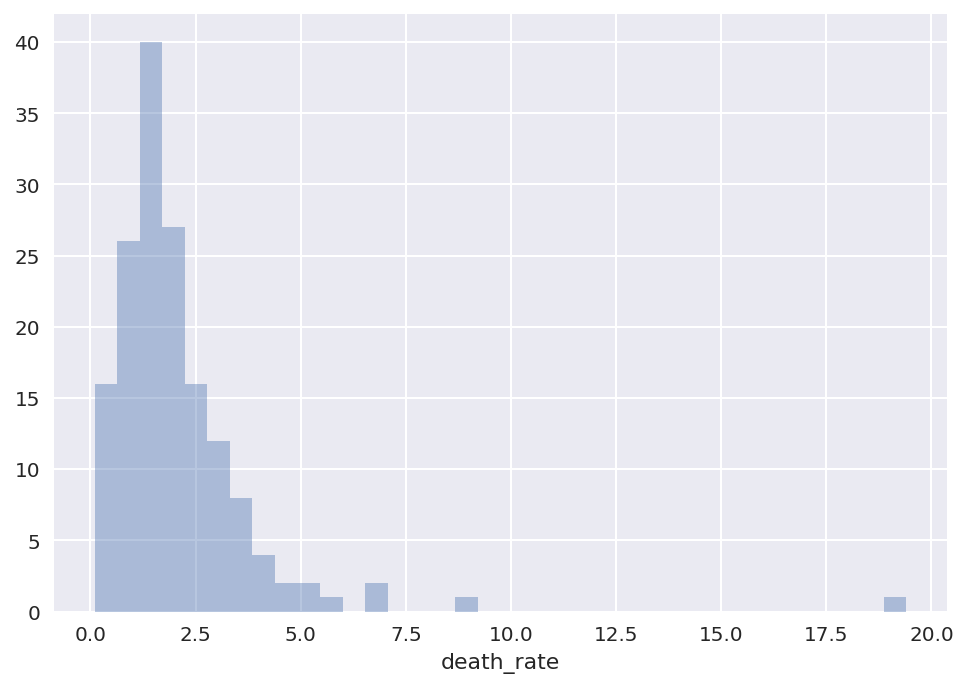

In [22]:
sns.distplot(df_latest.query('Confirmed >= 5000')['death_rate'], kde=False)

So, it is another reminder that KDE can be sometimes misleading at the edges as the recovery rate cannot be negative.

/home/dmdp/workspace/envs/p38gen/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


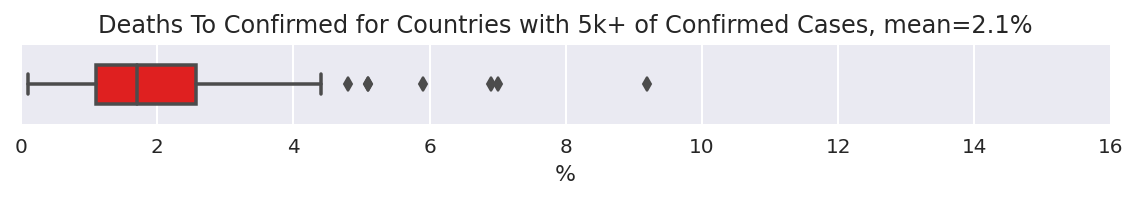

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 1.5))

dft = pd.DataFrame({'death_rate_all': df_latest.query('Confirmed >= 0')['death_rate'],
                    'death_rate_5k+': df_latest.query('Confirmed >= 5000')['death_rate']})

sns.boxplot(dft['death_rate_5k+'], ax=ax, color='red', width=0.5)

ax.set_xlabel('%')
ax.set_xlim([0, 16])

ax.set_title('Deaths To Confirmed for Countries with 5k+ of Confirmed Cases, mean={:.1f}%'.format(dft['death_rate_5k+'].mean()))

fig.tight_layout()

In [24]:
df['Country/Region'] = df['Country/Region'].astype('category')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'COVID-19 Death Rate')

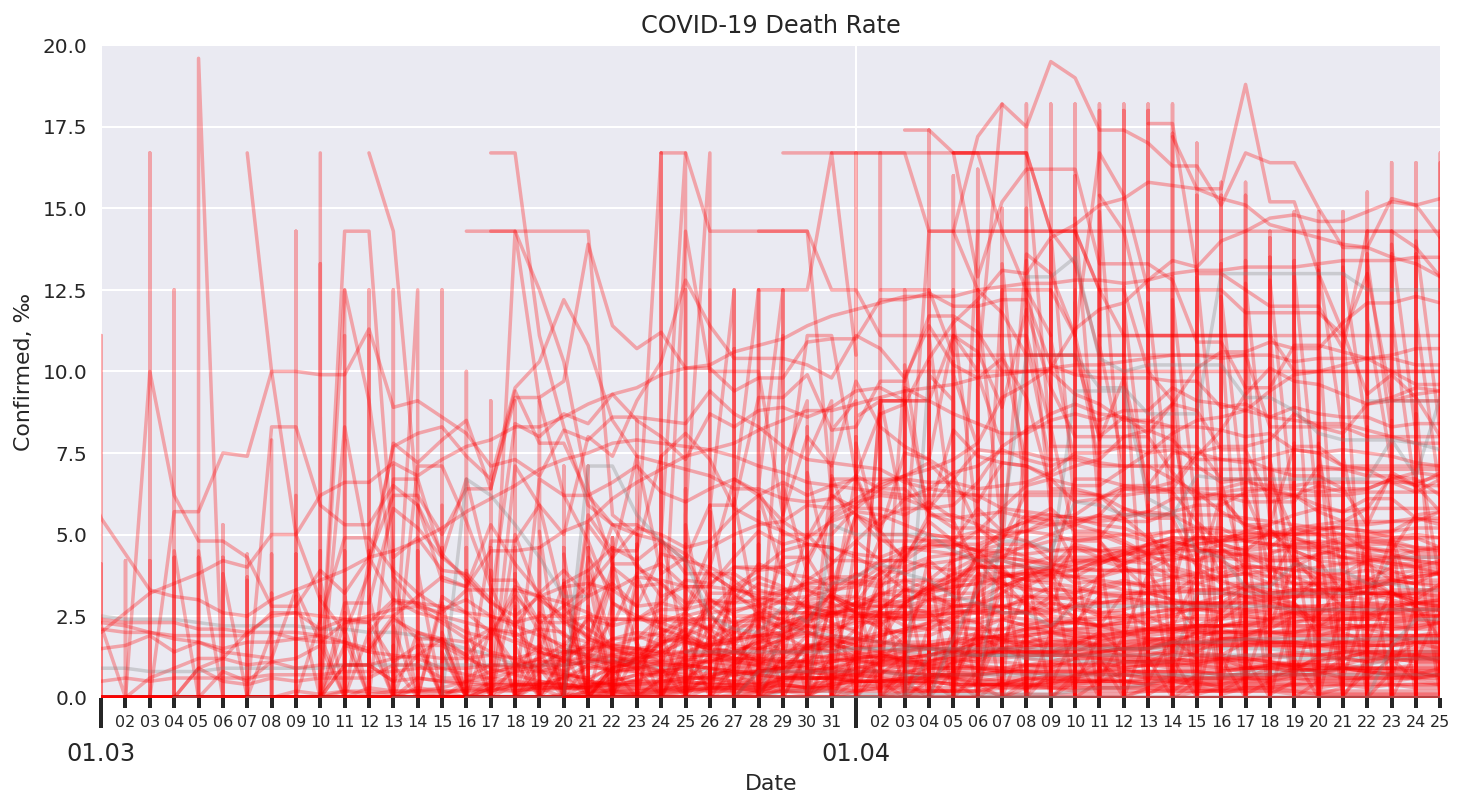

In [25]:
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for country in df['Country/Region'].unique():
    dft = df[df['Country/Region'] == country].copy()
    dft.loc[dft['death_rate'] >= 20, 'death_rate'] = np.nan
    confirmed = df_latest[df_latest['Country/Region'] == country]['Confirmed'].fillna(-1).iloc[0]
    if confirmed > 5000:
        color = 'red'
    else:
        color = 'gray'
    ax.plot(dft['ObservationDate'], dft['death_rate'], color=color, alpha=0.3)
    
# ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))

# setting tick parameters for all ticks at once
ax.tick_params(axis='x', which='major', width=2, length=15, labelsize=12)
ax.tick_params(axis='x', which='minor', width=2, length=5, labelsize=8)

# legend
ax.legend(fontsize=12)

# axis limits
ax.set_xlim(pd.to_datetime('2020-03-01'), pd.to_datetime('2020-04-25'))
ax.set_ylim([0, 20])

# titles
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed, ‰')

ax.set_title('COVID-19 Death Rate')

No handles with labels found to put in legend.


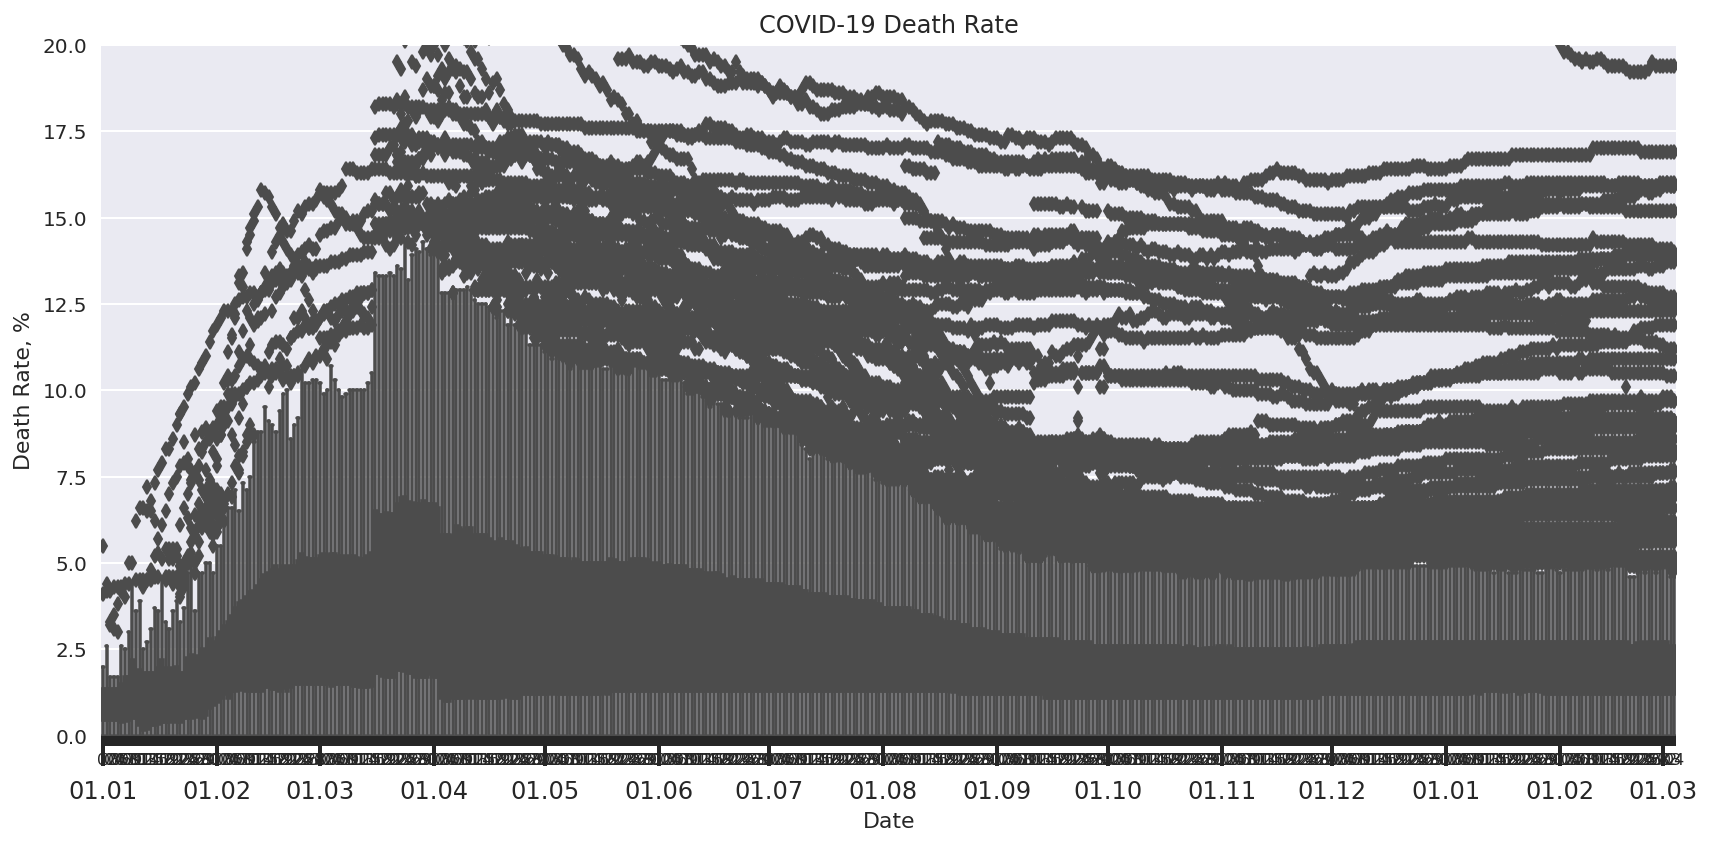

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# legend
ax.legend(fontsize=12)

obs_date_start = pd.to_datetime('2020-03-01')

sns.boxplot(x='ObservationDate', y='death_rate', data=df.query('Confirmed >= 500 and ObservationDate >= @obs_date_start'), ax=ax, color='red')

# ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))

# setting tick parameters for all ticks at once
ax.tick_params(axis='x', which='major', width=2, length=15, labelsize=12)
ax.tick_params(axis='x', which='minor', width=2, length=5, labelsize=8)

# titles
ax.set_xlabel('Date')
ax.set_ylabel('Death Rate, %')

# axis limits
# ax.set_xlim(pd.to_datetime('2020-03-01'), pd.to_datetime('2020-04-25'))
# axis limits
# ax.set_xlim('2020-03-01', '2020-06-10')
ax.set_ylim([0, 20])

ax.set_title('COVID-19 Death Rate')

fig.tight_layout()
fig.savefig('covid_death_rate_distr.png', dpi=300)

Countries listed in the order of dates when they have confirmed certain amount of cases

In [28]:
dfc = df.groupby(['Country/Region', 'ObservationDate'])[['Confirmed', 'Deaths', 'Recovered']].sum() \
    .reset_index()

dfc.query('1400 < Confirmed < 2000').groupby('Country/Region').head(1).sort_values('ObservationDate')

,Country/Region,ObservationDate,Confirmed,Deaths,Recovered
87832,South Korea,2020-02-27,1766,13,22
47673,Italy,2020-03-01,1694,34,83
45806,Iran,2020-03-02,1501,66,291
33204,France,2020-03-09,1401,25,12
88778,Spain,2020-03-10,1695,35,32
...,...,...,...,...,...
83044,Sao Tome and Principe,2021-02-10,1430,18,1079
81646,Saint Vincent and the Grenadines,2021-02-13,1418,6,554
73727,Papua New Guinea,2021-03-05,1492,16,846
16297,Cambodia,2021-03-16,1505,1,840


# Plots

We can build more or less the same plots with any of the three libraries: matplotlib, pandas and seaborn. The last two in fact use the former one.

In [29]:
df_latest_1k = df_latest.query('Confirmed >= 100').sort_values('death_rate')

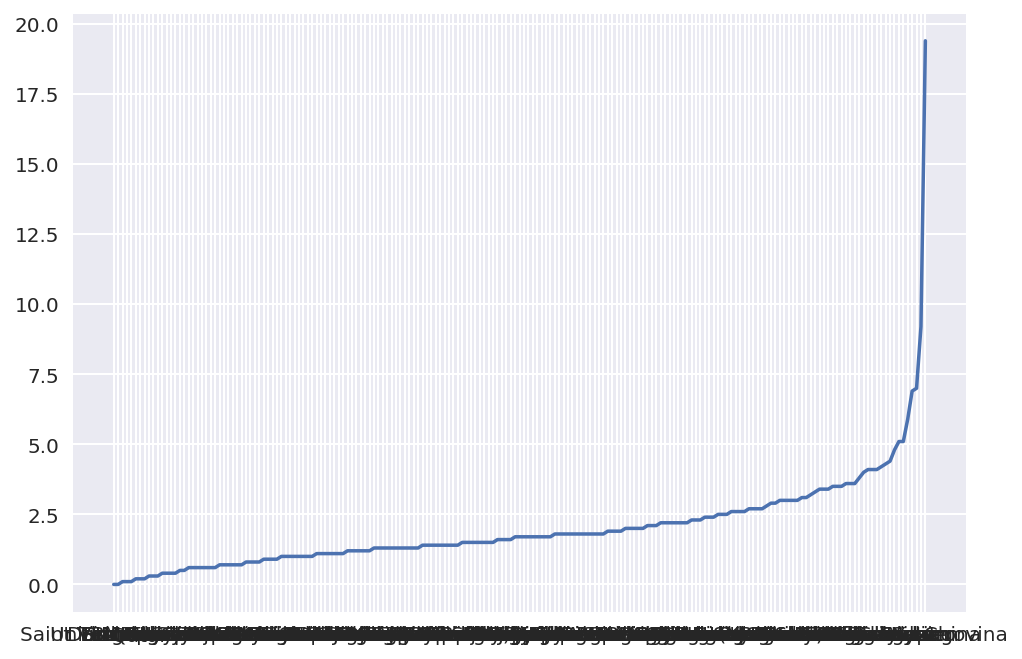

In [30]:
plt.plot(df_latest_1k['Country/Region'], df_latest_1k['death_rate'])

<AxesSubplot:xlabel='Country/Region'>

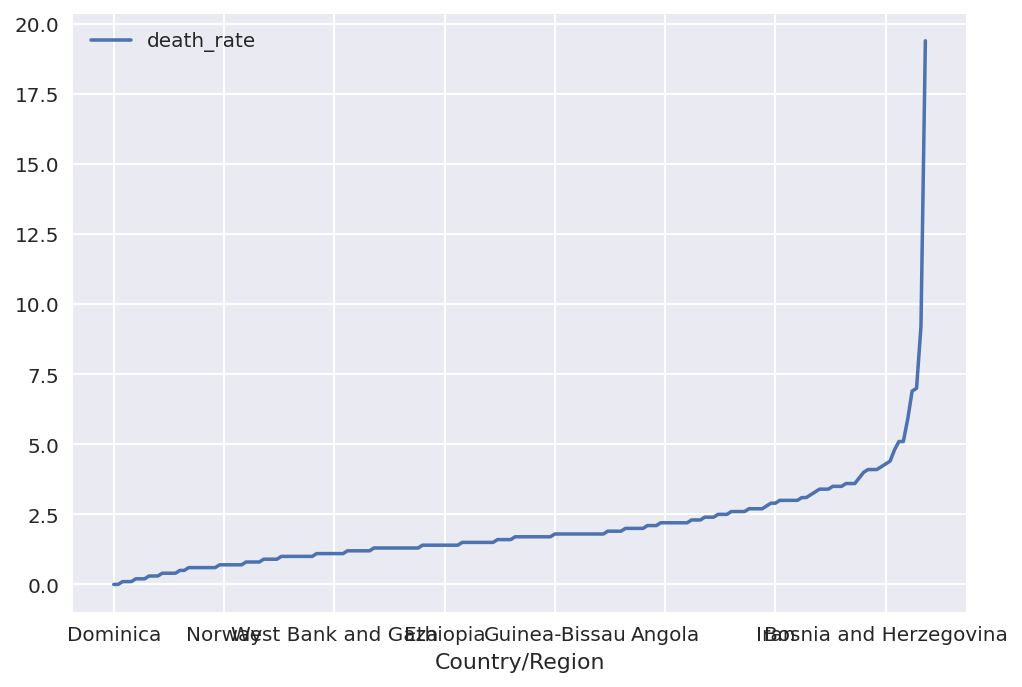

In [31]:
df_latest_1k.plot(x='Country/Region', y='death_rate')

<AxesSubplot:xlabel='Country/Region', ylabel='death_rate'>

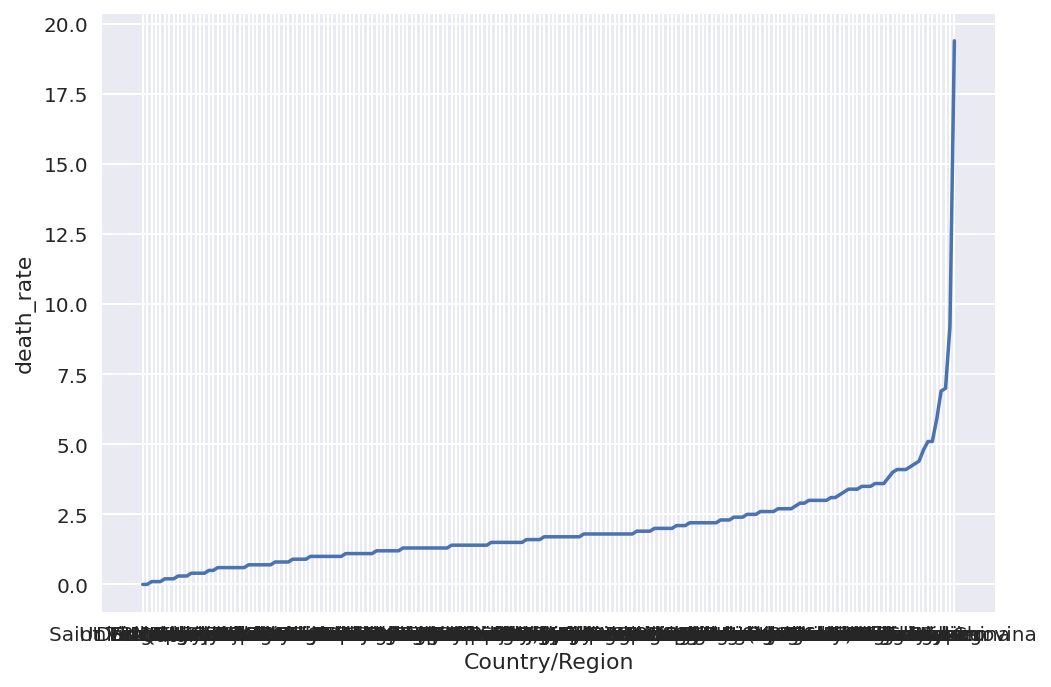

In [32]:
sns.lineplot(x=df_latest_1k['Country/Region'], y=df_latest_1k['death_rate'], sort=False)

So, you see that any of those three lines of code we get more or less same graphs but they are not quite elegant, there might be issues with tick labels, axis labels etc. That is why a decent looking graph usually required more lines of code than just one. Below, I provide a sort of template/workflow for creating an average graph, just to show what objects and functions of matplotlib is typically used.

# Template/Workflow

Check the link https://matplotlib.org/3.1.1/gallery/showcase/anatomy.html to understand parts of a typical matplotlib figure.

In [33]:
# define axes', each Axes is a powerful object which contains most of a graph elements (https://matplotlib.org/api/axes_api.html) 
# one figure can contain several axes

# draw basic plot with any of methods which is the most appropriate to your needs
# - call appropriate methods of Axes (see the Plotting section at the link) and pass data to it
# - call appropriate methods of DataFrame (see https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html) 
#   and pass names of columns to it.
# - call appropriate methods of seaborn (see the library documentation) and pass data to it (use 'data', 'x', 'y', 'hue' parameters)

# treat the tick frequency and their visual appearance

# treat the tick labels

# treat the legend

# add text notes, if required

# treat the titles

# (optional) tight the layout, it makes graphs to look more consistent

# (optional) save figure if you'd like to keep as a file 

# Axes

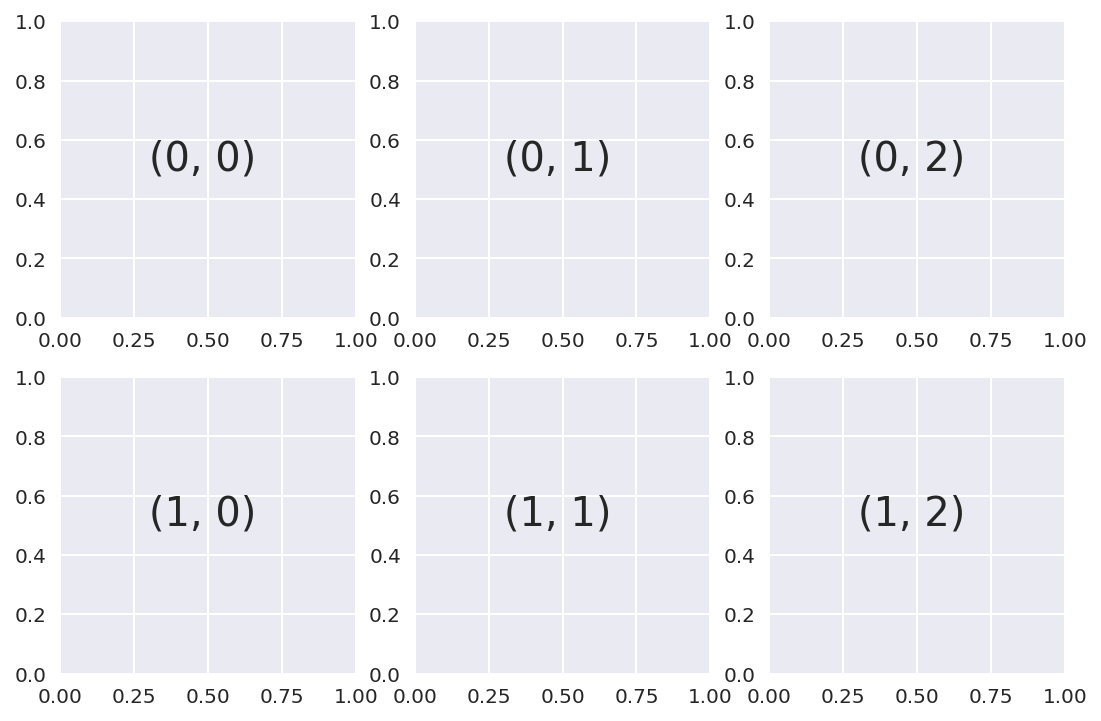

In [34]:
# small demonstration what Axes is

nrows = 2
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 6))

for i in range (nrows):
    for j in range(ncols):
        axs[i][j].text(0.3, 0.5, (i, j), fontsize=20)

# Graph

Our graph will show the number of confirmed cases for selected countries over time. As the graph has the time dimension we will need addiitonal modules from matplotlib to configure the axis.

In [35]:
def get_country_data(country, permille=True):
    
    """
    Returns data for a given country
    """
    
    dfr = df[df['Country/Region'] == country]\
        .groupby(['ObservationDate'])[['Confirmed', 'Deaths', 'Recovered']].sum() \
        .reset_index()\
        .copy()
    
    if permille:
        if country == 'Mainland China':
            country2 = 'China'
        elif country == 'Russia':
            country2 = 'Russian Federation'
        elif country == 'US':
            country2 = 'United States'
        else:
            country2 = country
        country_population = population[population['Country Name'] == country2]['2018']
        if len(country_population) == 0:
            raise ValueError
        dfr['confirmed_ppm'] = 1000 * dfr['Confirmed'] / country_population.iloc[0]
        dfr['death_ppm'] = 1000 * dfr['Deaths'] / country_population.iloc[0]
        
    return  dfr

In [36]:
population[population['Country Name'].str.contains('United')]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
6,United Arab Emirates,ARE,"Population, total",SP.POP.TOTL,92418.0,100796.0,112118.0,125130.0,138039.0,149857.0,...,8946777.0,9141596.0,9197910.0,9214175.0,9262900.0,9360980.0,9487203.0,9630959.0,NaN,NaN
79,United Kingdom,GBR,"Population, total",SP.POP.TOTL,52400000.0,52800000.0,53250000.0,53650000.0,54000000.0,54348050.0,...,63258810.0,63700215.0,64128273.0,64602298.0,65116219.0,65611593.0,66058859.0,66460344.0,NaN,NaN
249,United States,USA,"Population, total",SP.POP.TOTL,180671000.0,183691000.0,186538000.0,189242000.0,191889000.0,194303000.0,...,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,NaN,NaN


In [37]:
df_ch = get_country_data(country='Mainland China')
df_ir = get_country_data(country='Ireland')
df_it = get_country_data(country='Italy')
df_sp = get_country_data(country='Spain')
df_ru = get_country_data(country='Russia')
df_by = get_country_data(country='Belarus')
df_se = get_country_data(country='Sweden')
df_us = get_country_data(country='US')

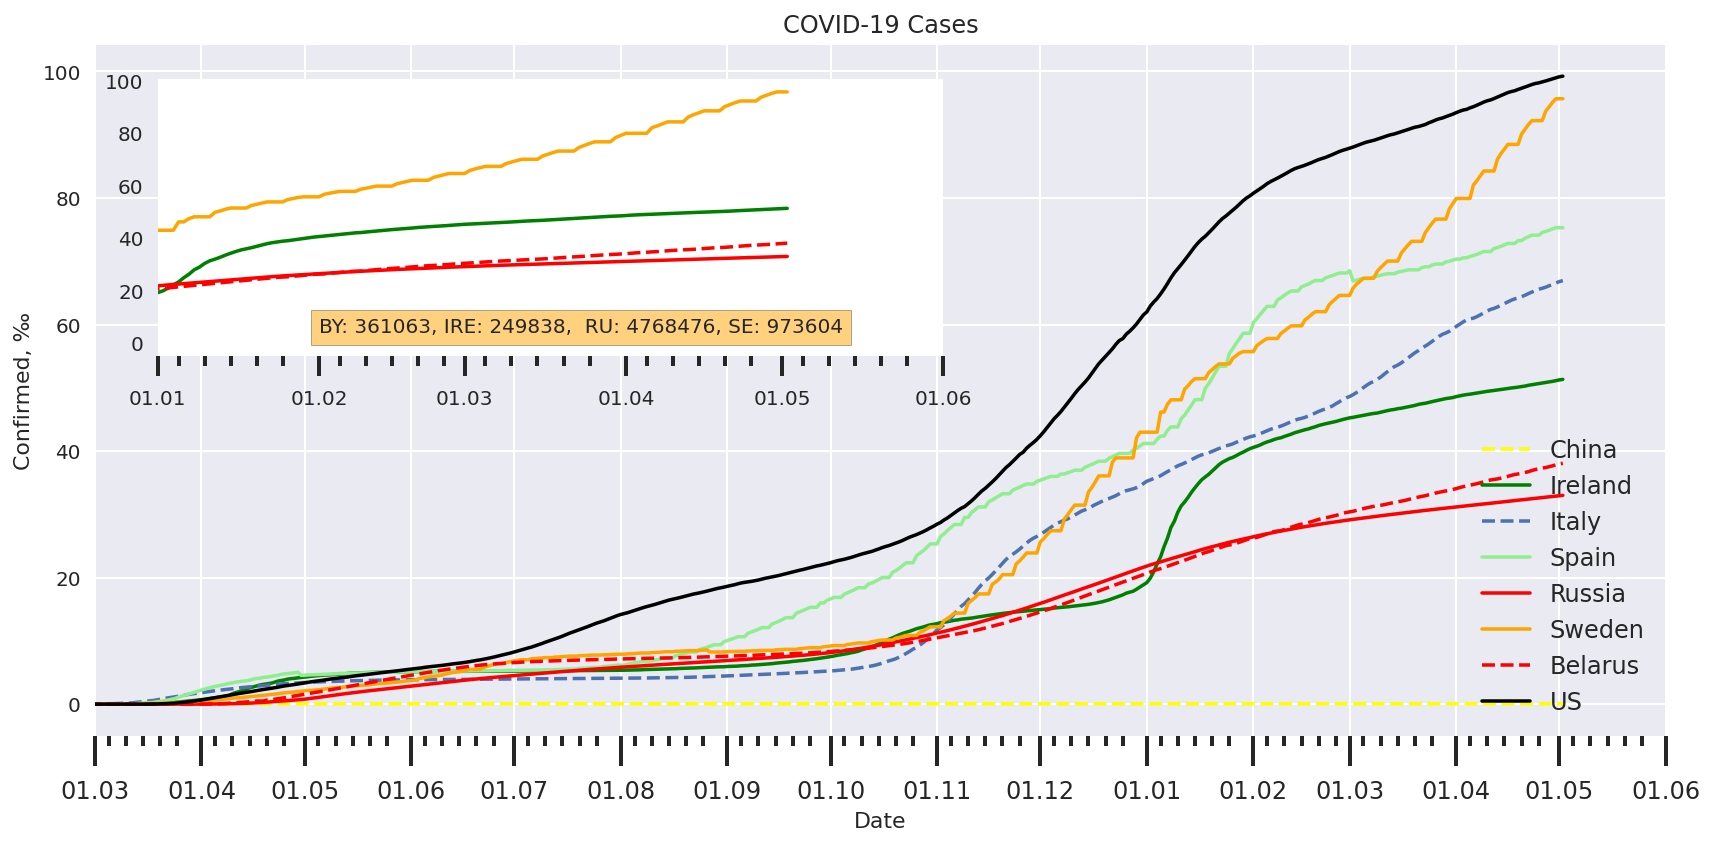

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# base plotting
ax.plot(df_ch['ObservationDate'], df_ch['confirmed_ppm'].astype('float'), label='China', linestyle='--', color='yellow')
ax.plot(df_ir['ObservationDate'], df_ir['confirmed_ppm'].astype('float'), label='Ireland', color='green')
ax.plot(df_it['ObservationDate'], df_it['confirmed_ppm'].astype('float'), label='Italy', linestyle='--', markersize=5)
ax.plot(df_sp['ObservationDate'], df_sp['confirmed_ppm'].astype('float'), label='Spain', color='lightgreen')
ax.plot(df_ru['ObservationDate'], df_ru['confirmed_ppm'].astype('float'), label='Russia', color='red')
ax.plot(df_se['ObservationDate'], df_se['confirmed_ppm'].astype('float'), label='Sweden', color='orange')
ax.plot(df_by['ObservationDate'], df_by['confirmed_ppm'].astype('float'), label='Belarus', linestyle='--', color='red')
ax.plot(df_us['ObservationDate'], df_us['confirmed_ppm'].astype('float'), label='US', marker='x', markersize=4, color='black')

# ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=[5, 10, 15, 20, 25]))
ax.xaxis.set_minor_formatter(mdates.DateFormatter(''))

# setting tick parameters for all ticks at once
ax.tick_params(axis='x', which='major', width=2, length=15, labelsize=12)
ax.tick_params(axis='x', which='minor', width=2, length=5, labelsize=8)

# legend
ax.legend(fontsize=12, loc='lower right')

# axis limits
ax.set_xlim(pd.to_datetime('2020-03-01'), pd.to_datetime('2021-06-01'))

# titles
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed, ‰')

ax.set_title('COVID-19 Cases')

# adding inset axes
ax2 = ax.inset_axes([0.04, 0.55, 0.5, 0.4])
ax2.set_facecolor('white')
ax2.plot(df_ir['ObservationDate'], df_ir['confirmed_ppm'].astype('float'), label='Ireland', color='green')
ax2.plot(df_ru['ObservationDate'], df_ru['confirmed_ppm'].astype('float'), label='Russia', color='red')
ax2.plot(df_by['ObservationDate'], df_by['confirmed_ppm'].astype('float'), label='Belarus', linestyle='--', color='red')
ax2.plot(df_se['ObservationDate'], df_se['confirmed_ppm'].astype('float'), label='Sweden', color='orange')

# ticks
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
ax2.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=[5, 10, 15, 20, 25]))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter(''))

# setting tick parameters for all ticks at once
ax2.tick_params(axis='x', which='major', width=2, length=10, labelsize=10)
ax2.tick_params(axis='x', which='minor', width=2, length=5, labelsize=7)

# axis limits
ax2.set_xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2021-06-01'))

# text
ax2.text(x=pd.to_datetime('2021-02-01'), y=4, \
         s='BY: {}, IRE: {},  RU: {}, SE: {}'.format(
                                             df_by.iloc[-1]['Confirmed'].round(2), \
                                             df_ir.iloc[-1]['Confirmed'].round(2), \
                                             df_ru.iloc[-1]['Confirmed'].round(2), \
                                             df_se.iloc[-1]['Confirmed'].round(2)), \
         bbox=dict(facecolor='orange', alpha=0.5))

# ax.set_yscale('log')

# tight it
fig.tight_layout()

# you can save the figure to a file in a chosen format (png, jpg, svg etc)
fig.savefig('covid_19_confirmed.png', dpi=300)
fig.savefig('covid_19_confirmed.svg')

Same code but for the number of deaths

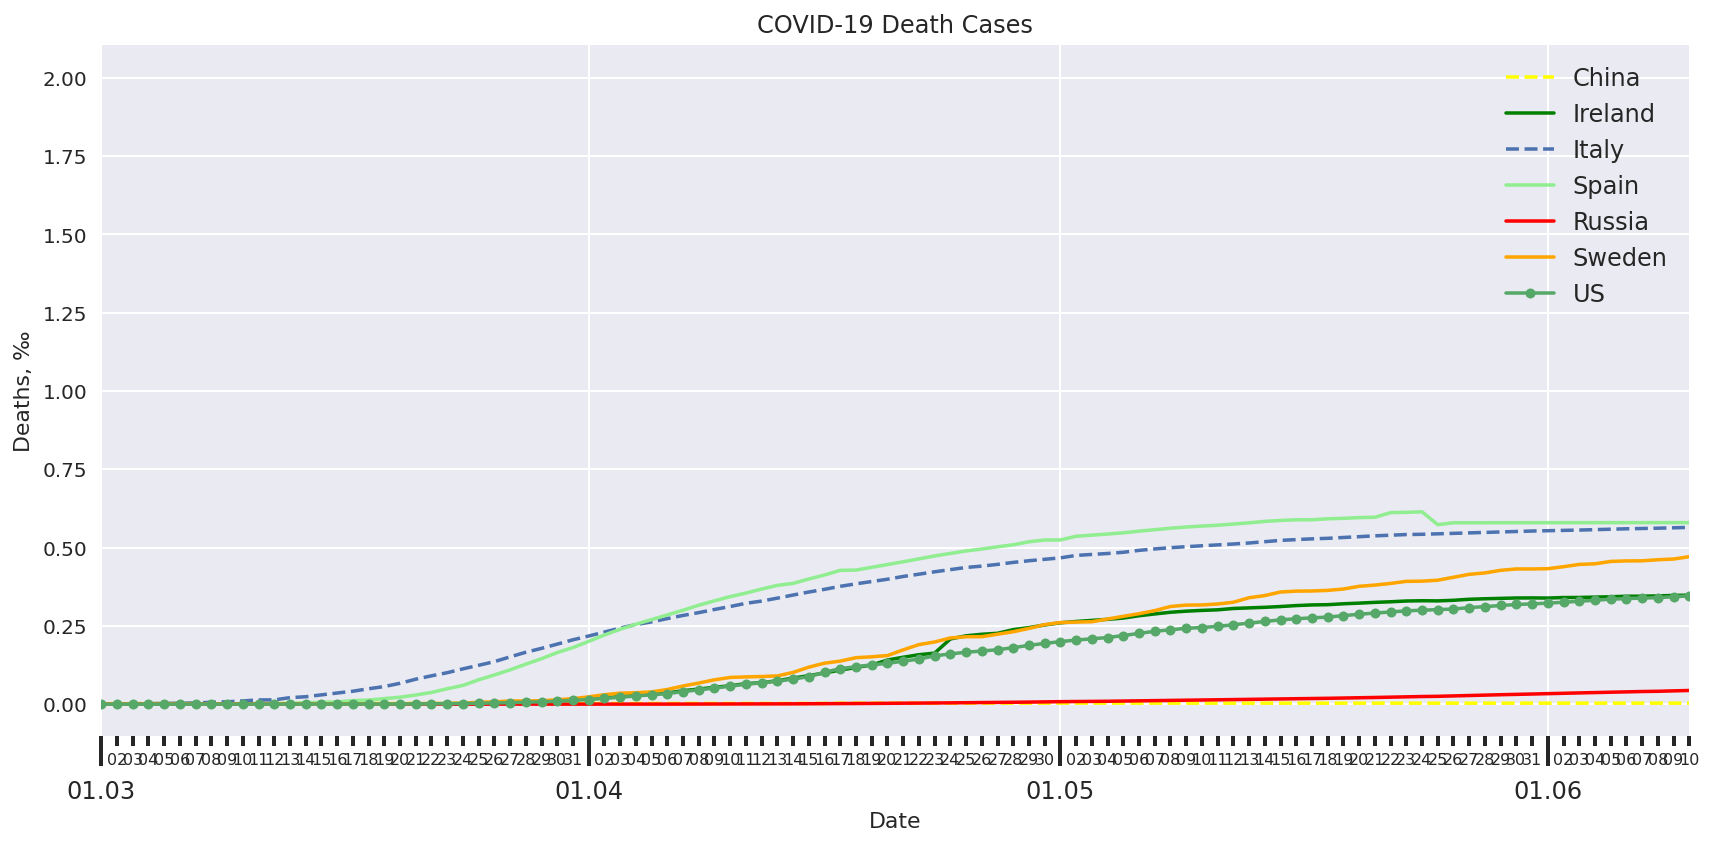

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# base plotting
# base plotting
ax.plot(df_ch['ObservationDate'], df_ch['death_ppm'].astype('float'), label='China', linestyle='--', color='yellow')
ax.plot(df_ir['ObservationDate'], df_ir['death_ppm'].astype('float'), label='Ireland', color='green')
ax.plot(df_it['ObservationDate'], df_it['death_ppm'].astype('float'), label='Italy', linestyle='--', markersize=5)
ax.plot(df_sp['ObservationDate'], df_sp['death_ppm'].astype('float'), label='Spain', color='lightgreen')
ax.plot(df_ru['ObservationDate'], df_ru['death_ppm'].astype('float'), label='Russia', color='red')
# ax.plot(df_by['ObservationDate'], df_by['confirmed_ppm'].astype('float'), label='Belarus', color='pink')
ax.plot(df_se['ObservationDate'], df_se['death_ppm'].astype('float'), label='Sweden', color='orange')
ax.plot(df_us['ObservationDate'], df_us['death_ppm'].astype('float'), label='US', marker='.', markersize=10)


# ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))

# setting tick parameters for all ticks at once
ax.tick_params(axis='x', which='major', width=2, length=15, labelsize=12)
ax.tick_params(axis='x', which='minor', width=2, length=5, labelsize=8)

# legend
ax.legend(fontsize=12)

# axis limits
ax.set_xlim(pd.to_datetime('2020-03-01'), pd.to_datetime('2020-06-10'))

# text
# ax.text(x=pd.to_datetime('2020-03-10'), y=300, s='People started worrying', bbox=dict(facecolor='orange', alpha=0.5))

# titles
ax.set_xlabel('Date')
ax.set_ylabel('Deaths, ‰')

ax.set_title('COVID-19 Death Cases')

# tight it
fig.tight_layout()

# you can save the figure to a file in a chosen format (png, jpg, svg etc)
fig.savefig('covid_19_deaths.png', dpi=300)

# Twin Axes

This is a small example with twin axes to build a plot with two Y-axis sharing the same X axis.

In [ ]:
fig = plt.figure(figsize=(12, 6))

# constructing Axes with two Y-axis
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
ax2 = ax1.twinx()

# base plots
ax1.plot(df_ch['ObservationDate'], df_ch['Recovered'].astype('int'), label='Mainland China', color='green')
ax1.plot(df_it['ObservationDate'], df_it['Recovered'].astype('int'), label='Italy', color='green', linestyle='--')

ax2.plot(df_ch['ObservationDate'], df_ch['Deaths'].astype('int'), label='Mainland China', color='red')
ax2.plot(df_it['ObservationDate'], df_it['Deaths'].astype('int'), label='Italy', color='red', linestyle='--')

# ticks
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
ax1.xaxis.set_minor_locator(mdates.DayLocator())
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))

# setting tick parameters for all ticks at once
ax1.tick_params(axis='x', which='major', width=2, length=15, labelsize=12)
ax1.tick_params(axis='x', which='minor', width=2, length=5, labelsize=8)

# axis limits
ax.set_xlim(pd.to_datetime('2020-02-01'), pd.to_datetime('2020-03-31'))

# titles
ax1.set_ylabel('Recovered')
ax1.set_ylabel('Deaths')

# legend
_ = fig.legend(loc="upper right", bbox_to_anchor=(0.3,0.9), bbox_transform=ax1.transAxes, fontsize=12)

# tight_layout is not compatible with twin Y axes
# fig.tight_layout()